**[Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)**

# Preprocessing
* * * *

In [1]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime

data = {
    'tra': pd.read_csv('../../../mltestdata/05_recruit/air_visit_data.csv'),
    'as': pd.read_csv('../../../mltestdata/05_recruit/air_store_info.csv'),
    'hs': pd.read_csv('../../../mltestdata/05_recruit/hpg_store_info.csv'),
    'ar': pd.read_csv('../../../mltestdata/05_recruit/air_reserve.csv'),
    'hr': pd.read_csv('../../../mltestdata/05_recruit/hpg_reserve.csv'),
    'id': pd.read_csv('../../../mltestdata/05_recruit/store_id_relation.csv'),
    'tes': pd.read_csv('../../../mltestdata/05_recruit/sample_submission.csv'),
    'hol': pd.read_csv('../../../mltestdata/05_recruit/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])


/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be remove

In [2]:
sub_index = data['tes'].id

In [3]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [4]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()

In [5]:
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2


In [6]:
# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [7]:
drop_list = ['visit_date','id']
train_dropped = train.drop(drop_list,axis=1)
test_dropped = test.drop(drop_list,axis=1)

test_dropped = test_dropped.drop("visitors",axis=1)

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_dropped['air_store_id'])
train_dropped['air_store_id'] = le.fit_transform(train_dropped['air_store_id'])
test_dropped['air_store_id'] = le.fit_transform(test_dropped['air_store_id'])

In [9]:
X_train = train_dropped.drop(['visitors'], axis=1)
y_train = (train_dropped['visitors'].values)

In [1]:
X_train.tail()

NameError: name 'X_train' is not defined

# Data Exploring
* * * *

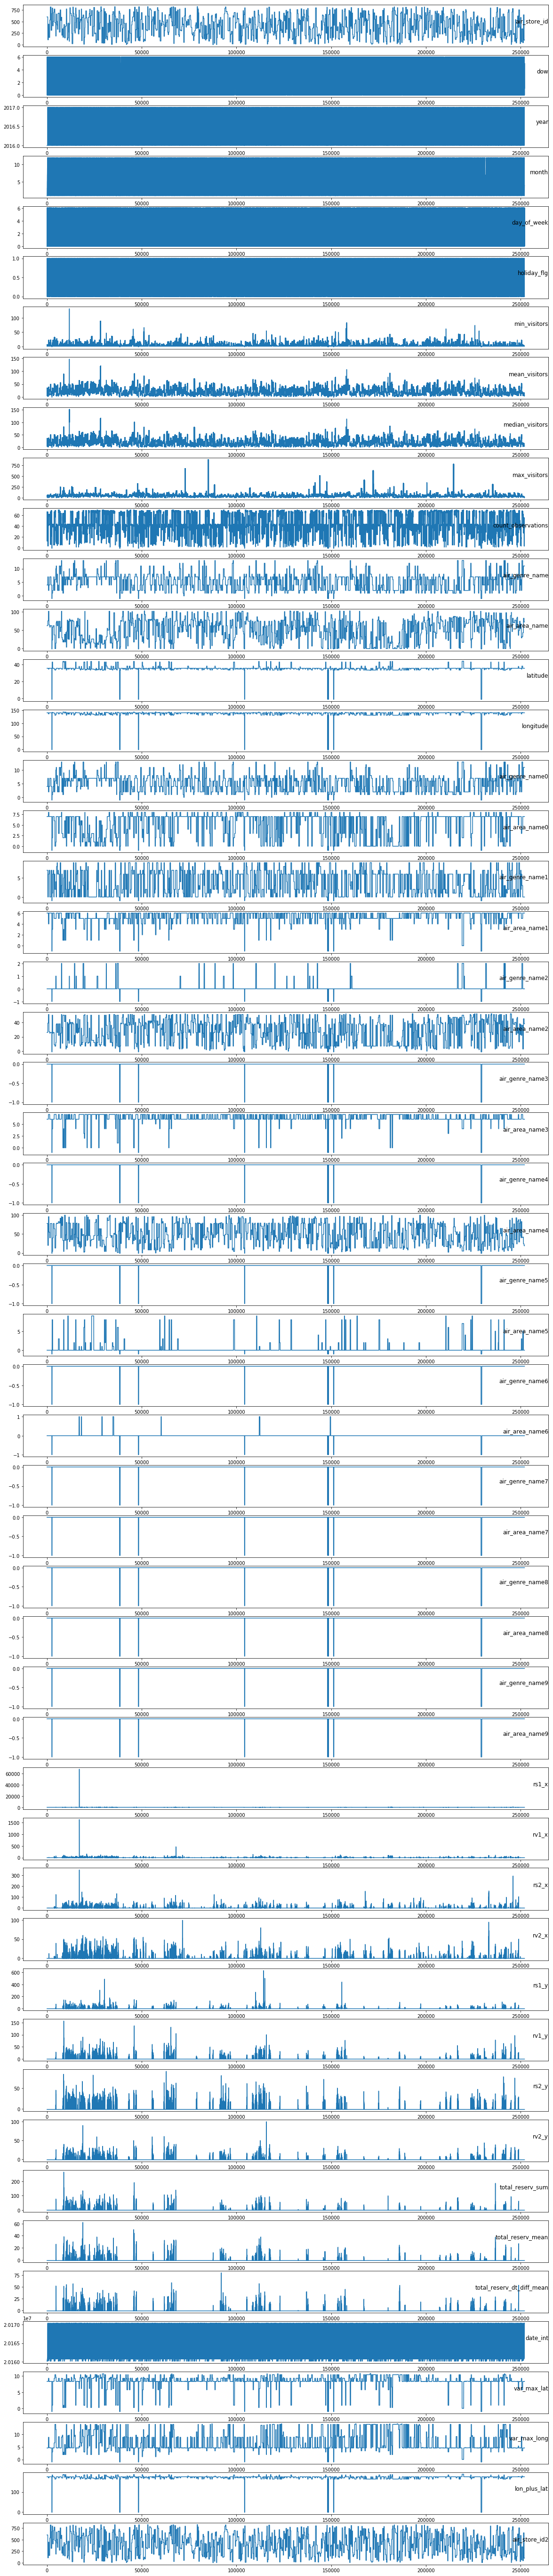

In [14]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from matplotlib import pyplot
# load dataset
dataset = X_train.copy()
values = dataset.values
# specify columns to plot

#groups = [0, 1, 2, 3, 5, 6, 7]
groups = [x for x in range(len(dataset.columns))]
i = 1
# plot each column
pyplot.figure(figsize=(20,100))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [15]:
dataset.shape

(252108, 51)

In [16]:
dataset.head()

,air_store_id,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,603,2,2016,1,6,0,7.0,23.843750,25.0,57.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160113,8.362564,4.521799,175.409667,603
1,603,3,2016,1,4,0,2.0,20.292308,21.0,54.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160114,8.362564,4.521799,175.409667,603
2,603,4,2016,1,0,0,4.0,34.738462,35.0,61.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160115,8.362564,4.521799,175.409667,603
3,603,5,2016,1,2,0,6.0,27.651515,27.0,53.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160116,8.362564,4.521799,175.409667,603
4,603,0,2016,1,1,0,2.0,13.754386,12.0,34.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160118,8.362564,4.521799,175.409667,603


In [17]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [23]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [24]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [25]:
reframed.shape

(252107, 102)

In [26]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(51,102)]], axis=1, inplace=True)
print(reframed.head())
print(reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.728261   0.333333        0.0        0.0   1.000000        0.0   
2   0.728261   0.500000        0.0        0.0   0.666667        0.0   
3   0.728261   0.666667        0.0        0.0   0.000000        0.0   
4   0.728261   0.833333        0.0        0.0   0.333333        0.0   
5   0.728261   0.000000        0.0        0.0   0.166667        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)     ...      var42(t-1)  \
1   0.060150   0.167378   0.169935    0.066059     ...             0.0   
2   0.022556   0.143452   0.143791    0.062642     ...             0.0   
3   0.037594   0.240779   0.235294    0.070615     ...             0.0   
4   0.052632   0.193032   0.183007    0.061503     ...             0.0   
5   0.022556   0.099404   0.084967    0.039863     ...             0.0   

   var43(t-1)  var44(t-1)  var45(t-1)  var46(t-1)  var47(t-1)  var48(t-1)  \
1         0.0         0.0         0.0         0.0  

# Modeling - Multivariate LSTM Forecast Model
### Define and Fit Model
* * * * *

In [29]:
# split into train and test sets
values = reframed.values
n_train_days = 365
#n_train_hours = 365 * 24

In [41]:
dataset.head()

,air_store_id,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,...,rs2_y,rv2_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,603,2,2016,1,6,0,7.0,23.843750,25.0,57.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160113,8.362564,4.521799,175.409667,603
1,603,3,2016,1,4,0,2.0,20.292308,21.0,54.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160114,8.362564,4.521799,175.409667,603
2,603,4,2016,1,0,0,4.0,34.738462,35.0,61.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160115,8.362564,4.521799,175.409667,603
3,603,5,2016,1,2,0,6.0,27.651515,27.0,53.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160116,8.362564,4.521799,175.409667,603
4,603,0,2016,1,1,0,2.0,13.754386,12.0,34.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,20160118,8.362564,4.521799,175.409667,603


In [31]:
#train = values[:n_train_hours, :]
#test = values[n_train_hours:, :]

train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [50]:
train.shape

(365, 51)

In [32]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [33]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 1, 50) (365,) (251742, 1, 50) (251742,)


In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Train on 365 samples, validate on 251742 samples
Epoch 1/50
 - 3s - loss: 0.8322 - val_loss: 0.3617
Epoch 2/50
 - 3s - loss: 0.3940 - val_loss: 0.2622
Epoch 3/50
 - 2s - loss: 0.0792 - val_loss: 0.3783
Epoch 4/50
 - 2s - loss: 0.1425 - val_loss: 0.3055
Epoch 5/50
 - 2s - loss: 0.0554 - val_loss: 0.2649
Epoch 6/50
 - 2s - loss: 0.0538 - val_loss: 0.3093
Epoch 7/50
 - 2s - loss: 0.0702 - val_loss: 0.3107
Epoch 8/50
 - 2s - loss: 0.0388 - val_loss: 0.2751
Epoch 9/50
 - 2s - loss: 0.0230 - val_loss: 0.3082
Epoch 10/50
 - 2s - loss: 0.0394 - val_loss: 0.2877
Epoch 11/50
 - 3s - loss: 0.0232 - val_loss: 0.2958
Epoch 12/50
 - 3s - loss: 0.0261 - val_loss: 0.2889
Epoch 13/50
 - 3s - loss: 0.0241 - val_loss: 0.2936
Epoch 14/50
 - 2s - loss: 0.0218 - val_loss: 0.2888
Epoch 15/50
 - 2s - loss: 0.0197 - val_loss: 0.2958
Epoch 16/50
 - 3s - loss: 0.0187 - val_loss: 0.2864
Epoch 17/50
 - 3s - loss: 0.0105 - val_loss: 0.2933
Epoch 18/50
 - 2s - loss: 0.0125 - val_loss: 0.2959
Epoch 19/50
 - 3s - loss

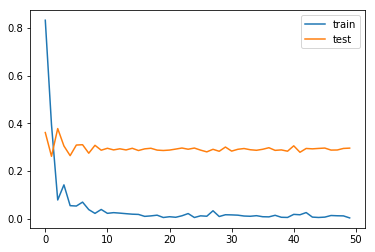

In [35]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [37]:
test_X.shape

(251742, 50)

In [38]:
yhat.shape

(251742, 1)

In [40]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: operands could not be broadcast together with shapes (251742,50) (51,) (251742,50) 

In [48]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: operands could not be broadcast together with shapes (243347,50) (51,) (243347,50) 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def RMSLE(y, pred):
    return mean_squared_error(y, pred)**0.5


# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# https://www.kaggle.com/marknagelberg/caterpillar-tube-pricing/rmsle-function
def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


In [ ]:
# calculate RMSE
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

# calculate RMSLE
rmsle = 

print('Test RMSE: %.3f' % rmse)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
# =================================================
# model_selection.GridSearchCV
# =================================================
# 1) xgboostモデルの作成
reg = xgb.XGBRegressor()

# 2) XGBoost params

#XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
#       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
#       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#       silent=True, subsample=1)

xgb_params = {
    'objective' : ['reg:gamma','reg:linear'], 
    'learning_rate' : [0.09,0.1],
    'n_estimators' : [80,100,120],
    'max_depth' : [3,4,5],
    'subsample' : [0.9,1],
    'colsample_bytree' : [0.9,1.0],
    'min_child_weight' : [0.9,1]
}

# 3) Run GridSearch
grid_xgb = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

# 4) Show best Params and Score
print("_"*30)
print("Result of Gridsearch")
print("Best params: ", grid_xgb.best_params_)
print("Best Estimator: ", grid_xgb.best_estimator_)
print("MSE: ", grid_xgb.best_score_)

# 5) Learning with best params
xgr_g = xgb.XGBRegressor(**grid_xgb.best_params_)
xgr_g.fit(X_train, y_train)
y_pred_gs = xgr_g.predict(X_test)

# 6) The error metric: RMSE
print("_"*30)
print("vs Prediction")
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 193.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 639.7min


In [72]:
predictions = xgr_g.predict(test_dropped)

In [73]:
sub = pd.DataFrame({"id": sub_index, "visitors": predictions})
sub.to_csv('submission_recruit_02Jan18_v01.csv', index=False)

In [74]:
sub_csv = pd.read_csv('./rs_submission_01Jan18_v04.csv')

In [75]:
sub_csv.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,3.133897
1,air_00a91d42b08b08d9_2017-04-24,21.227549
2,air_00a91d42b08b08d9_2017-04-25,23.996819
3,air_00a91d42b08b08d9_2017-04-26,28.515388
4,air_00a91d42b08b08d9_2017-04-27,30.262386


In [ ]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5
    
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), model1.predict(train[col])))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), model2.predict(train[col])))
test['visitors'] = (model1.predict(test[col]) + model2.predict(test[col])) / 2
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
del train; del data;


In [6]:
# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../../../mltestdata/05_recruit/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = (sub_merge['visitors_x'] + sub_merge['visitors_y']* 1.1)/2
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)

In [7]:
sub_merge.head()

,id,visitors_x,visitors_y,visitors
0,air_00a91d42b08b08d9_2017-04-23,2.555948,2.000000,2.377974
1,air_00a91d42b08b08d9_2017-04-24,20.944645,23.621632,23.464220
2,air_00a91d42b08b08d9_2017-04-25,25.206066,26.823130,27.355755
3,air_00a91d42b08b08d9_2017-04-26,27.570890,27.600920,28.965951
4,air_00a91d42b08b08d9_2017-04-27,31.519827,31.299646,32.974719
